# Job Search Model with Markov State

This algorithmn solves the **Job Search Model** using **Markov Chains** to model wage dynamics. The model is based on the following key components:

1. **Model Setup and Markov Chain Approximation**: Use `namedtuple` to define the model and then use `tauchen` function from `quantecon` to approximate a Markov process for wages.
2. **Bellman Operator and Successive Approximation**: Define Bellman operator and implement successive approximate algorithmn to slove the optimal value function.
3. **Greedy Policy**: The optimal policy (v-greedy policy) is derived, determining whether a job seeker should accept a wage offer or continue searching.
4. **Visualization**: The stopping and continuation values are plotted to illustrate the decision-making process.


In [291]:
from quantecon.markov import tauchen
import numpy as np
from numba import jit
from scipy.stats import norm
from collections import namedtuple
import matplotlib.pyplot as plt

### Section 1: Model Setup and Markov Chain Approximation

In [269]:
Model = namedtuple("Model", ("n", "w_vals", "P", "β", "c"))

In [306]:

def tauchen_handmade(n_states, ρ, σ, n_std=3):
    std_y = σ / np.sqrt(1 - ρ**2) # standard deviation of y
    y_vals = np.linspace(-n_std * std_y, n_std * std_y, n_states) # y_vals are the grid points
    y_vals.shape = (n_states, 1) # make it a column vector
    half_d = (y_vals[1] - y_vals[0]) / 2 # half the distance between two grid points
    P = np.zeros((n_states, n_states))

    for i in range(n_states):
        for j in range(n_states):
            if j == 0:
                P[i, j] = norm.cdf((y_vals[0] + half_d - ρ * y_vals[i]) / σ)
            elif j == n_states - 1:
                P[i, j] = 1 - norm.cdf((y_vals[n_states - 1] - half_d - ρ * y_vals[i]) / σ)
            else:
                P[i, j] = norm.cdf((y_vals[j] + half_d - ρ * y_vals[i]) / σ) - \
                          norm.cdf((y_vals[j] - half_d - ρ * y_vals[i]) / σ)
    return y_vals, P


### Note
$$ y_{t+1} = \rho y_{t} + \varepsilon_t,   \quad \varepsilon_t \sim N(0,\sigma)$$
Therefore $\mathbb{P}(y_{t+1} \in (y_{val}[j] - \frac{d}{2}, y_{val}[j] + \frac{d}{2}) \mid y_t) = \mathbb{P}(\varepsilon_t \in (y_{val}[j] - \frac{d}{2} - \rho y_t, y_{val}[j] + \frac{d}{2} - \rho y_t))$

In [271]:
def generate_stochastic_matrix(n):
    """
    Generates a transition matrix.
    """
    P = np.random.rand(n, n)
    P = P / np.repeat(P.sum(axis=1, keepdims=True), n, axis=1)  # Normalize rows to sum to 1
    return P


In [286]:
def create_markov_js_model1(
        n=200,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.98,      # discount factor
        c=1.0,        # unemployment compensation
        version=0
    ):
    """
    Default.
    """
    if version ==0:
        mc = tauchen(n, ρ, ν)
        w_vals, P = np.exp(mc.state_values), mc.P
   
        
    if version == 1:
        w_vals, P = tauchen_handmade(n, ρ, ν)
        w_vals = np.exp(w_vals) 
     
    else:
        mc = tauchen(n, ρ, ν)
        P_prime = generate_stochastic_matrix(n)
        w_vals, P = np.exp(mc.state_values), P_prime
        
       
    w_vals.shape = (n, 1)
    return Model(n=n, w_vals=w_vals, P=P, β=β, c=c)

model = create_markov_js_model1(n=200, ρ=0.9, ν=0.2, β=0.98, c=1.0, version=1)


C:\Users\Ewarde\AppData\Local\Temp\ipykernel_19316\138201354.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[i, j] = norm.cdf((y_vals[0] + half_d - ρ * y_vals[i]) / σ)
C:\Users\Ewarde\AppData\Local\Temp\ipykernel_19316\138201354.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[i, j] = norm.cdf((y_vals[j] + half_d - ρ * y_vals[i]) / σ) - \
C:\Users\Ewarde\AppData\Local\Temp\ipykernel_19316\138201354.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P

array([[2.56664823e-01, 2.27800718e-02, 2.37195498e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.37021785e-01, 2.18767580e-02, 2.28772433e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.18234711e-01, 2.09280326e-02, 2.19795353e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.79058988e-38, 2.59786516e-38, 6.31592257e-38, ...,
        2.19795353e-02, 2.09280326e-02, 2.18234711e-01],
       [7.95876761e-39, 1.16306102e-38, 2.83982838e-38, ...,
        2.28772433e-02, 2.18767580e-02, 2.37021785e-01],
       [3.52388773e-39, 5.18687679e-39, 1.27193504e-38, ...,
        2.37195498e-02, 2.27800718e-02, 2.56664823e-01]])

In [290]:
def create_markov_js_model1(
        n=200,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.98,      # discount factor
        c=1.0,        # unemployment compensation
    ):
    """
    Default.
    """
   
    mc = tauchen(n, ρ, ν)
    w_vals, P = np.exp(mc.state_values), mc.P
        
       
    w_vals.shape = (n, 1)
    return Model(n=n, w_vals=w_vals, P=P, β=β, c=c)




In [288]:
model.w_vals

array([[0.25246203],
       [0.25597889],
       [0.25954474],
       [0.26316027],
       [0.26682615],
       [0.27054311],
       [0.27431184],
       [0.27813307],
       [0.28200754],
       [0.28593597],
       [0.28991913],
       [0.29395778],
       [0.29805268],
       [0.30220463],
       [0.30641441],
       [0.31068284],
       [0.31501073],
       [0.31939891],
       [0.32384822],
       [0.3283595 ],
       [0.33293363],
       [0.33757148],
       [0.34227394],
       [0.3470419 ],
       [0.35187628],
       [0.356778  ],
       [0.36174801],
       [0.36678725],
       [0.37189668],
       [0.3770773 ],
       [0.38233008],
       [0.38765603],
       [0.39305618],
       [0.39853155],
       [0.40408319],
       [0.40971217],
       [0.41541956],
       [0.42120646],
       [0.42707397],
       [0.43302322],
       [0.43905534],
       [0.44517149],
       [0.45137284],
       [0.45766057],
       [0.4640359 ],
       [0.47050003],
       [0.47705422],
       [0.483

In [273]:
def create_markov_js_model2(
        n=200,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.98,      # discount factor
        c=1.0        # unemployment compensation
    ):
    """
    Use tauchen_handmade.
    """
    w_vals, P = tauchen_handmade(n, ρ, ν)
    w_vals = np.exp(w_vals) 
    w_vals.shape = (n, 1) # reshape to column vector
    return Model(n=n, w_vals=w_vals, P=P, β=β, c=c)


In [274]:
def create_markov_js_model3(
        n=200,       # wage grid size
        ρ=0.9,       # wage persistence
        ν=0.2,       # wage volatility
        β=0.98,      # discount factor
        c=1.0        # unemployment compensation
    ):
    """
    Use randomly generated transition matrix.
    """
    mc = tauchen(n, ρ, ν)
    P_prime = generate_stochastic_matrix(n)
    w_vals, P = np.exp(mc.state_values), P_prime
    w_vals.shape = (n, 1)
    return Model(n=n, w_vals=w_vals, P=P, β=β, c=c)


### Section 2: Bellman Operator and Successive Approximation

In [303]:

def creat_bellman_op(Model):
    """
    Define Bellman operation by packing a function inside a function.
    """
    n, w_vals, P, β, c = Model
    @jit
    def bellman_op(v):
        # Bellman operator
        return np.maximum(w_vals / (1 - β), c + β * P @ v)
    
    return bellman_op
#model1 = create_markov_js_model1(n=200, ρ=0.9, ν=0.2, β=0.98, c=1.0)
#bellman_op = creat_bellman_op(model1)

In [295]:
def direct_define(Model, v):
    """
    Directly define the Bellman operator
    """
    n, w_vals, P, β, c = Model
    return np.maximum(w_vals / (1 - β), c + β * P @ v)

### Note

$P$ is the transition matrix, and $P_{ij}$ is the probability $\mathbb{P}(W_{t+1} = w_j \mid W_{t} = w_i) $. Write $P = \begin{bmatrix}p_1^T\\ p_2^T\\ ...\\p_n^T\\ \end{bmatrix}$, $$p_i^T v(w) = \sum_{j = 1}^{n} \mathbb{P}(W_{t+1} = w_j \mid W_{t} = w_i) v(w_j) = \mathbb{E}_t(v(W_{t+1})\mid W_{t} = w_i)$$
So, each row of `P @ v` is the expected value under different wage offer at time $t$, and each row of `w_vals` is the stopping value under $W_t = w_i$.

In [296]:
def s_appro(T, v0, itermax=10000, tolerance=10^-6):
    """
    Successive approach
    """
    itertime = 0
    error = 1
    v_old = v0
    v_new = v0
    while itertime < itermax and error > tolerance:
        v_new = T(v_old)
        error = np.max(np.abs(v_new - v_old))
        itertime = itertime + 1
        v_old = v_new
    return v_new

### Section 3: Greedy Policy

**Definition** (v-greedy policy):
$$
\sigma(w) = \mathbb{1} \left\{ \frac{w'}{1 - \beta} \geq c + \beta \sum_{w'} v(w') P(w, w') \right\}
$$

In [278]:
def get_greedy(v_star, Model):
    _, w_vals, P, β, c = Model
    stopping_value = w_vals / (1 - β)
    continuation_value = c + β * (P @ v_star)
    return stopping_value >= continuation_value

### Section 4: Visualization

In [297]:
def plot(model_all, v_star_all):
    """
    Plot the stopping and continuation values
    """
    fig, axes = plt.subplots(1, len(model_all), figsize=(15, 5), sharey=True)
    i = 0
    for model, v_star in zip(model_all, v_star_all):
        stopping_value = model.w_vals / (1 - model.β)
        continuation_value = model.c + model.β * (model.P @ v_star)

        policy = get_greedy(v_star, model)
        index = np.argmin(np.abs(stopping_value - continuation_value))  # Find the index of the closest value
        adjustment = stopping_value[index]
        policy = adjustment * np.array(policy, dtype=float)  # Adjust policy values
        policy.shape = (model.n, 1)  # Reshape to column vector
        ## Can this be done in a more elegant way?
        
        ax = axes[i]
        ax.plot(model.w_vals, stopping_value, linestyle='--', label='Stopping Value')
        ax.plot(model.w_vals, continuation_value, linestyle='--', label='Continuation Value')
        ax.plot(model.w_vals, policy, label='Policy')
    
        ax.set_xlabel('Wage')
        ax.set_ylabel('Value')
        ax.set_title(f'Model {i+1}')
        ax.legend()
        i += 1


In [307]:
model1 = create_markov_js_model1(n=300)
model2 = create_markov_js_model2(n=300)
model3 = create_markov_js_model3(n=300)

C:\Users\Ewarde\AppData\Local\Temp\ipykernel_19316\1669510192.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[i, j] = norm.cdf((y_vals[0] + half_d - ρ * y_vals[i]) / σ)
C:\Users\Ewarde\AppData\Local\Temp\ipykernel_19316\1669510192.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[i, j] = norm.cdf((y_vals[j] + half_d - ρ * y_vals[i]) / σ) - \
C:\Users\Ewarde\AppData\Local\Temp\ipykernel_19316\1669510192.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


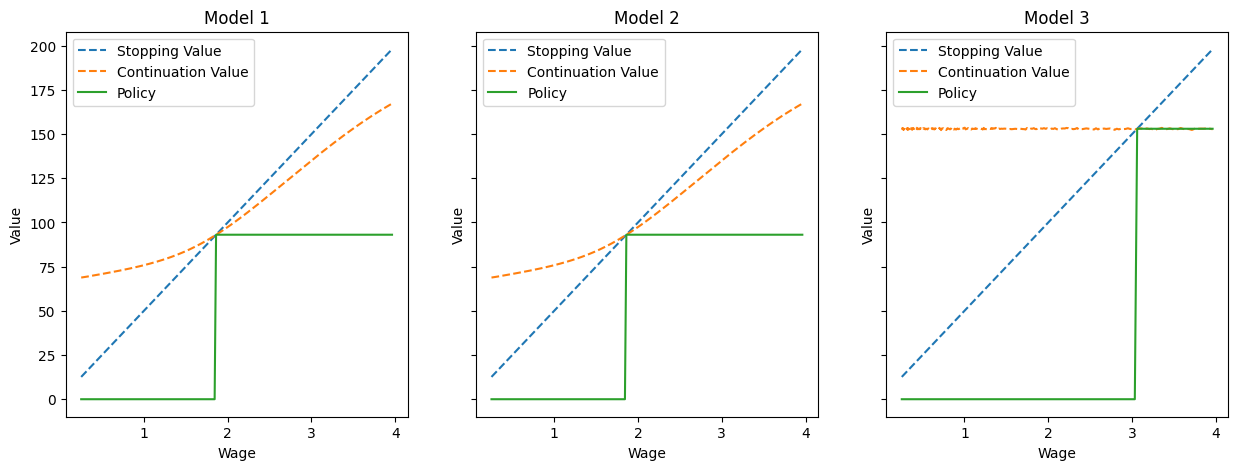

In [309]:
model_all = [model1, model2, model3]
v_star_all = [s_appro(creat_bellman_op(model), np.zeros([model.n, 1])) for model in model_all]

plot(model_all, v_star_all)
plt.show()
    